<a href="https://colab.research.google.com/github/teamsimcoemmai/mmai894/blob/894-GavinLei/ResNet34_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The experiment inspired by Sean Sungil Kim's work:  
https://github.com/kimx3314/Stanford-Cars-Dataset-Vehicle-Recognition

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from fastai.vision import *
from fastai.metrics import error_rate
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from glob import iglob
from IPython.core.display import Image, display
import cv2
import time
from fastai.callbacks import *

In [3]:
def random_seed(seed_value, use_cuda):  #gleaned from multiple forum posts
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: torch.cuda.manual_seed_all(seed_value) # gpu 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
random_seed(42,True)
data = ImageDataBunch.from_folder('/content/drive/MyDrive/Simcoe/894/Car dataset/new','train_set','val_set','test_set', seed=42,
                                  ds_tfms=get_transforms(do_flip=False, 
                                                         flip_vert=True, 
                                                         p_affine=0.75, # Default value
                                                         max_rotate=5.0, 
                                                         max_zoom=1.1,
                                                         max_warp=0.2,
                                                         p_lighting=0.75, # Defalut value 
                                                         max_lighting=0.2,                                                                                                                  ),
                                                         size=224,
                                                         bs=32).normalize(imagenet_stats)
                                                  

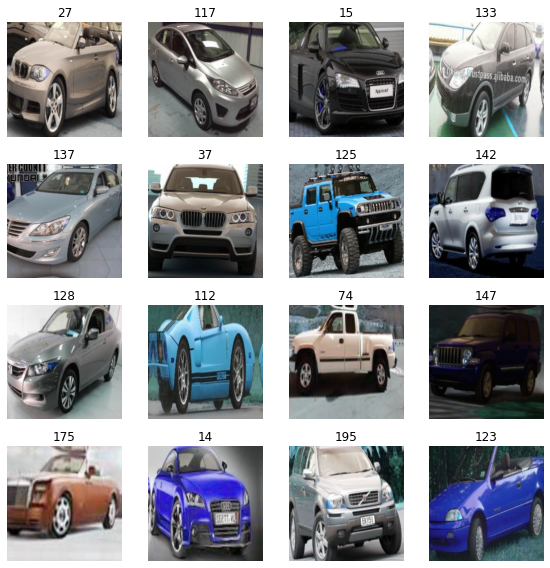

In [6]:
# preview of training data generated from ImageDataBunch
data.show_batch(rows = 4, figsize = (8, 8))

In [7]:
# loading the pre-trained ResNet34 cnn
random_seed(42,True)
learn = cnn_learner(data, models.resnet34, pretrained = True, metrics = accuracy,\
                    callback_fns = ShowGraph, model_dir = "/content/drive/MyDrive/894GroupProject/ResNet34/1/")

learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.

Total wd and lr analysis runtime: 88.63326406478882


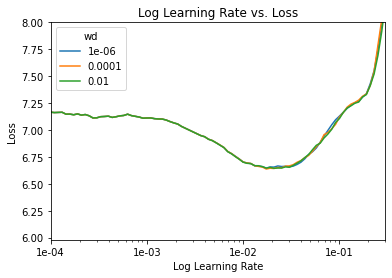

In [8]:
lr_List = []
loss_List = []
wd_List = [1e-6, 1e-4, 1e-2]

start_ts = time.time()

for wd in wd_List:
    random_seed(42,True)
    exp_learn = cnn_learner(data, models.resnet34, pretrained = True, metrics = accuracy,\
                            model_dir = "/content/drive/MyDrive/894GroupProject/ResNet34/2/")
    random_seed(42,True)
    exp_learn.lr_find(wd = wd, num_it = 200)
    lr_List.append(exp_learn.recorder.lrs)
    loss_List.append(exp_learn.recorder.losses)

min_y = 6
max_y = 8
_, ax = plt.subplots(1, 1)
for i in range(len(loss_List)):
    ax.plot(lr_List[i], loss_List[i])
    min_y = min(np.asarray(loss_List[i]).min(), min_y)
ax.set_title('Log Learning Rate vs. Loss'), ax.set_ylabel('Loss'), ax.set_xlabel('Log Learning Rate')
ax.set_xscale('log'), ax.set_xlim((1e-4,3e-1)), ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wd_List, title = 'wd'), ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
print("\nTotal wd and lr analysis runtime:", time.time() - start_ts)


epoch,train_loss,valid_loss,accuracy,time
0,3.829317,2.595927,0.376853,10:03
1,3.043182,2.687991,0.362850,01:01
2,2.381100,2.060227,0.462521,01:01
3,1.998270,1.792346,0.521829,01:00
4,1.556260,1.429902,0.618616,01:01
5,1.303963,1.015923,0.716639,01:00
6,1.001042,0.773893,0.789539,01:01
7,0.726892,0.638683,0.822488,01:01
8,0.572419,0.582619,0.831960,01:00
9,0.489518,0.578332,0.838962,01:00


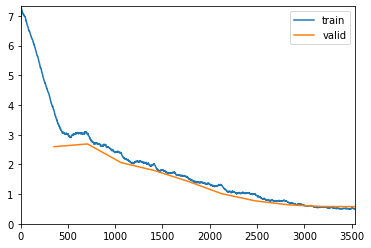

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet34_phase1.pth')

In [9]:
random_seed(42,True)
learn.fit_one_cycle(10, max_lr = 1e-2, wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet34_phase1', return_path = True)


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


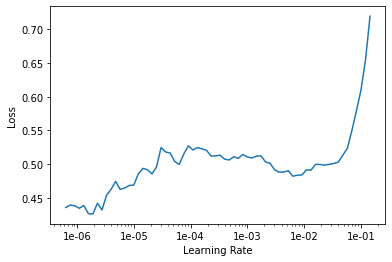

In [10]:
random_seed(42,True)
learn.lr_find(wd = 1e-2)
learn.recorder.plot()


epoch,train_loss,valid_loss,accuracy,time
0,1.608371,1.953343,0.511944,01:02
1,1.843258,2.160002,0.430395,01:02
2,1.815721,2.887919,0.348435,01:03
3,1.490005,1.328331,0.632619,01:03
4,1.154939,1.109641,0.687397,01:03
5,0.833800,0.775103,0.778007,01:03
6,0.612013,0.527751,0.844316,01:04
7,0.400246,0.429016,0.875618,01:04
8,0.267503,0.383626,0.887150,01:04
9,0.221682,0.368293,0.889209,01:04


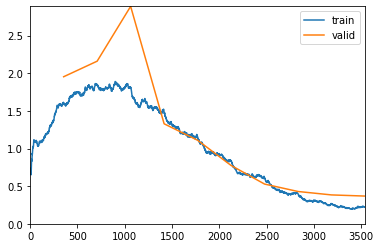

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet34_phase21.pth')

In [11]:
learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet34_phase1')
learn.unfreeze()
random_seed(42,True)
# learn.fit_one_cycle(10, max_lr = slice(2e-5, 2e-4), wd = 1e-2)
learn.fit_one_cycle(10, max_lr = slice(1e-3, 1e-2), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet34_phase21', return_path = True)


epoch,train_loss,valid_loss,accuracy,time
0,0.625432,0.675704,0.812191,01:04
1,0.895404,1.161973,0.684514,01:03
2,0.794726,1.207000,0.673394,01:04
3,0.560599,0.818096,0.768534,01:04
4,0.356984,0.621259,0.823723,01:04
5,0.254479,0.529330,0.844316,01:03
6,0.192852,0.456464,0.867381,01:03
7,0.161577,0.387924,0.888385,01:05
8,0.153268,0.365909,0.891269,01:04
9,0.160761,0.366412,0.894563,01:04


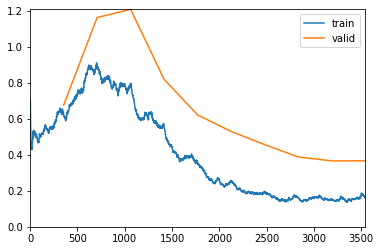

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet34_phase22.pth')

In [12]:
learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet34_phase1')
learn.unfreeze()
random_seed(42,True)
# learn.fit_one_cycle(10, max_lr = slice(2e-5, 2e-4), wd = 1e-2)
learn.fit_one_cycle(10, max_lr = slice(1e-4, 1e-3), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet34_phase22', return_path = True)


epoch,train_loss,valid_loss,accuracy,time
0,0.458675,0.566549,0.842669,01:03
1,0.450793,0.560129,0.836079,01:02
2,0.379912,0.539132,0.845964,01:02
3,0.236282,0.552402,0.837727,01:03
4,0.142715,0.507408,0.850906,01:02
5,0.097638,0.481727,0.852554,01:02
6,0.070983,0.452311,0.862438,01:03
7,0.084800,0.446645,0.868616,01:02
8,0.166816,0.434445,0.869440,01:02
9,0.226273,0.437657,0.871499,01:03


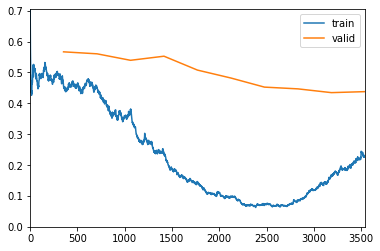

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet34_phase23.pth')

In [13]:
learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet34_phase1')
learn.unfreeze()
random_seed(42,True)
# learn.fit_one_cycle(10, max_lr = slice(2e-5, 2e-4), wd = 1e-2)
learn.fit_one_cycle(10, max_lr = slice(1e-5, 1e-4), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet34_phase23', return_path = True)

epoch,train_loss,valid_loss,accuracy,time
0,0.467055,0.567434,0.844316,01:03
1,0.517106,0.613973,0.819193,01:03
2,0.432018,0.561083,0.835667,01:03
3,0.283679,0.612654,0.823723,01:04
4,0.166433,0.521728,0.845964,01:04
5,0.114782,0.470356,0.864498,01:04
6,0.082559,0.441142,0.869440,01:04
7,0.088753,0.417961,0.878089,01:04
8,0.143912,0.402104,0.882208,01:04
9,0.179430,0.404491,0.879325,01:04


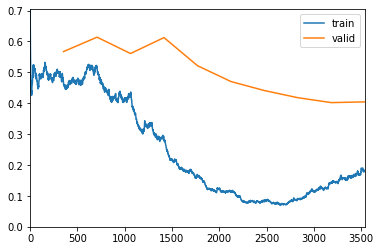

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet34_phase24.pth')

In [15]:
learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet34_phase1')
learn.unfreeze()
random_seed(42,True)
# learn.fit_one_cycle(10, max_lr = slice(2e-5, 2e-4), wd = 1e-2)
learn.fit_one_cycle(10, max_lr = slice(2e-5, 2e-4), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet34_phase24', return_path = True)

epoch,train_loss,valid_loss,accuracy,time
0,0.480777,0.577609,0.839374,01:04
1,0.580452,0.681318,0.801895,01:04
2,0.498692,0.620674,0.820840,01:04
3,0.342166,0.632826,0.815074,01:04
4,0.203417,0.514444,0.853789,01:04
5,0.144548,0.466139,0.863262,01:04
6,0.095763,0.430551,0.868616,01:04
7,0.098466,0.403674,0.883855,01:06
8,0.140695,0.388953,0.884267,01:05
9,0.161256,0.390943,0.884679,01:04


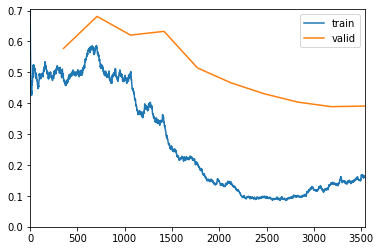

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet34_phase25.pth')

In [16]:
learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet34_phase1')
learn.unfreeze()
random_seed(42,True)
# learn.fit_one_cycle(10, max_lr = slice(2e-5, 2e-4), wd = 1e-2)
learn.fit_one_cycle(10, max_lr = slice(3e-5, 3e-4), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet34_phase25', return_path = True)

epoch,train_loss,valid_loss,accuracy,time
0,0.852717,1.019152,0.719522,01:04
1,1.143849,1.579720,0.580313,01:04
2,1.022531,1.354371,0.642092,01:04
3,0.728068,1.128472,0.684926,01:04
4,0.481255,0.827592,0.761532,01:04
5,0.341606,0.629583,0.821252,01:04
6,0.274048,0.465713,0.865733,01:04
7,0.211249,0.399119,0.888385,01:04
8,0.184355,0.375694,0.899506,01:04
9,0.166628,0.371451,0.897858,01:04


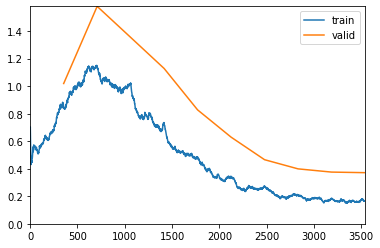

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet34_phase26.pth')

In [17]:
learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet34_phase1')
learn.unfreeze()
random_seed(42,True)
# learn.fit_one_cycle(10, max_lr = slice(2e-5, 2e-4), wd = 1e-2)
learn.fit_one_cycle(10, max_lr = slice(2e-4, 2e-3), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet34_phase26', return_path = True)

epoch,train_loss,valid_loss,accuracy,time
0,1.269150,1.641647,0.581137,01:03
1,1.501970,1.738565,0.532125,01:03
2,1.339004,2.129448,0.470346,01:03
3,1.050331,1.249555,0.651153,01:03
4,0.749287,0.826218,0.768122,01:03
5,0.569809,0.602162,0.828666,01:04
6,0.400083,0.509826,0.852142,01:04
7,0.278484,0.387697,0.883031,01:04
8,0.212392,0.359318,0.900329,01:04
9,0.203789,0.355211,0.901565,01:04


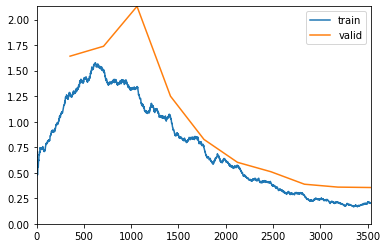

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet34_phase27.pth')

In [18]:
learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet34_phase1')
learn.unfreeze()
random_seed(42,True)
# learn.fit_one_cycle(10, max_lr = slice(2e-5, 2e-4), wd = 1e-2)
learn.fit_one_cycle(10, max_lr = slice(5e-4, 5e-3), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet34_phase27', return_path = True)

epoch,train_loss,valid_loss,accuracy,time
0,1.496858,1.758951,0.540774,01:04
1,1.684722,1.720394,0.542010,01:04
2,1.654640,1.971343,0.489703,01:03
3,1.342084,1.605639,0.573723,01:03
4,1.001128,1.175857,0.670099,01:03
5,0.790407,0.682310,0.801895,01:02
6,0.540488,0.512111,0.852965,01:03
7,0.360528,0.409038,0.878501,01:03
8,0.262502,0.366289,0.896211,01:03
9,0.215180,0.357257,0.897035,01:03


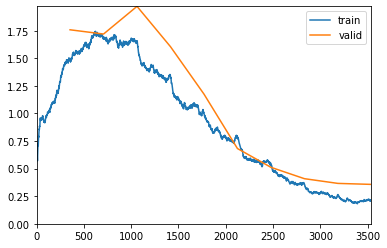

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet34_phase28.pth')

In [19]:
learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet34_phase1')
learn.unfreeze()
random_seed(42,True)
# learn.fit_one_cycle(10, max_lr = slice(2e-5, 2e-4), wd = 1e-2)
learn.fit_one_cycle(10, max_lr = slice(8e-4, 8e-3), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet34_phase28', return_path = True)

epoch,train_loss,valid_loss,accuracy,time
0,1.360831,1.907663,0.528830,01:03
1,1.554272,1.779106,0.509061,01:02
2,1.446364,1.668982,0.549012,01:02
3,1.123414,1.348370,0.640445,01:03
4,0.836187,1.001417,0.717463,01:02
5,0.623955,0.736683,0.788715,01:05
6,0.466417,0.519348,0.854201,01:03
7,0.328480,0.406098,0.885502,01:03
8,0.235102,0.369304,0.896211,01:02
9,0.195133,0.365364,0.897858,01:03


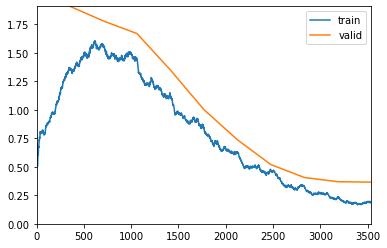

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet34_phase29.pth')

In [20]:
learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet34_phase1')
learn.unfreeze()
random_seed(42,True)
# learn.fit_one_cycle(10, max_lr = slice(2e-5, 2e-4), wd = 1e-2)
learn.fit_one_cycle(10, max_lr = slice(6e-4, 6e-3), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet34_phase29', return_path = True)

epoch,train_loss,valid_loss,accuracy,time
0,0.659346,0.608749,0.828254,01:03
1,0.568331,0.577377,0.830725,01:03
2,0.465068,0.560221,0.836079,01:03
3,0.396104,0.670990,0.805601,01:03
4,0.336601,0.648491,0.818781,01:03
5,0.358068,0.678812,0.801483,01:03
6,0.457458,0.786093,0.777183,01:03
7,0.557469,0.717154,0.789951,01:03
8,0.695897,0.832096,0.762768,01:03
9,0.725078,0.783252,0.787891,01:03


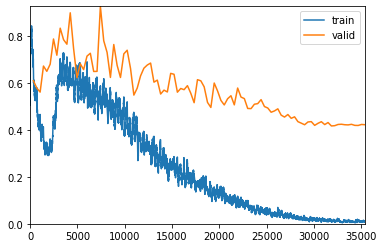

PosixPath('/content/drive/MyDrive/894GroupProject/ResNet34_phase29-F.pth')

In [25]:
learn = learn.load('/content/drive/MyDrive/894GroupProject/ResNet34_phase1')
learn.unfreeze()
random_seed(42,True)
# learn.fit_one_cycle(10, max_lr = slice(2e-5, 2e-4), wd = 1e-2)
learn.fit_one_cycle(100, max_lr = slice(6e-4, 6e-3), wd = 1e-2)
learn.save('/content/drive/MyDrive/894GroupProject/ResNet34_phase29-F', return_path = True)

In [26]:
learn1 = learn.load('/content/drive/MyDrive/894GroupProject/ResNet34_phase1')
random_seed(42,True)
val_preds1, val_targets1 = learn1.get_preds()
preds1 = val_preds1.tolist()
cls_preds1 = np.array([pred1.index(max(pred1))for pred1 in preds1])
precision1, recall1, fscore1, support1 = precision_recall_fscore_support(np.array(val_targets1), cls_preds1, average = 'weighted')
print('The precision score is', precision1, '\nThe recall score is', recall1, '\nThe fscore score is', fscore1)

The precision score is 0.8522225671856407 
The recall score is 0.8389621087314663 
The fscore score is 0.8381705083546198


In [27]:
learn2 = learn.load('/content/drive/MyDrive/894GroupProject/ResNet34_phase29-F')
random_seed(42,True)
val_preds2, val_targets2 = learn2.get_preds()
preds2 = val_preds2.tolist()
cls_preds2 = np.array([pred2.index(max(pred2))for pred2 in preds2])
precision2, recall2, fscore2, support2 = precision_recall_fscore_support(np.array(val_targets2), cls_preds2, average = 'weighted')
print('The precision score is', precision2, '\nThe recall score is', recall2, '\nThe fscore score is', fscore2)

The precision score is 0.9367576295196771 
The recall score is 0.9320428336079077 
The fscore score is 0.9319959265152914


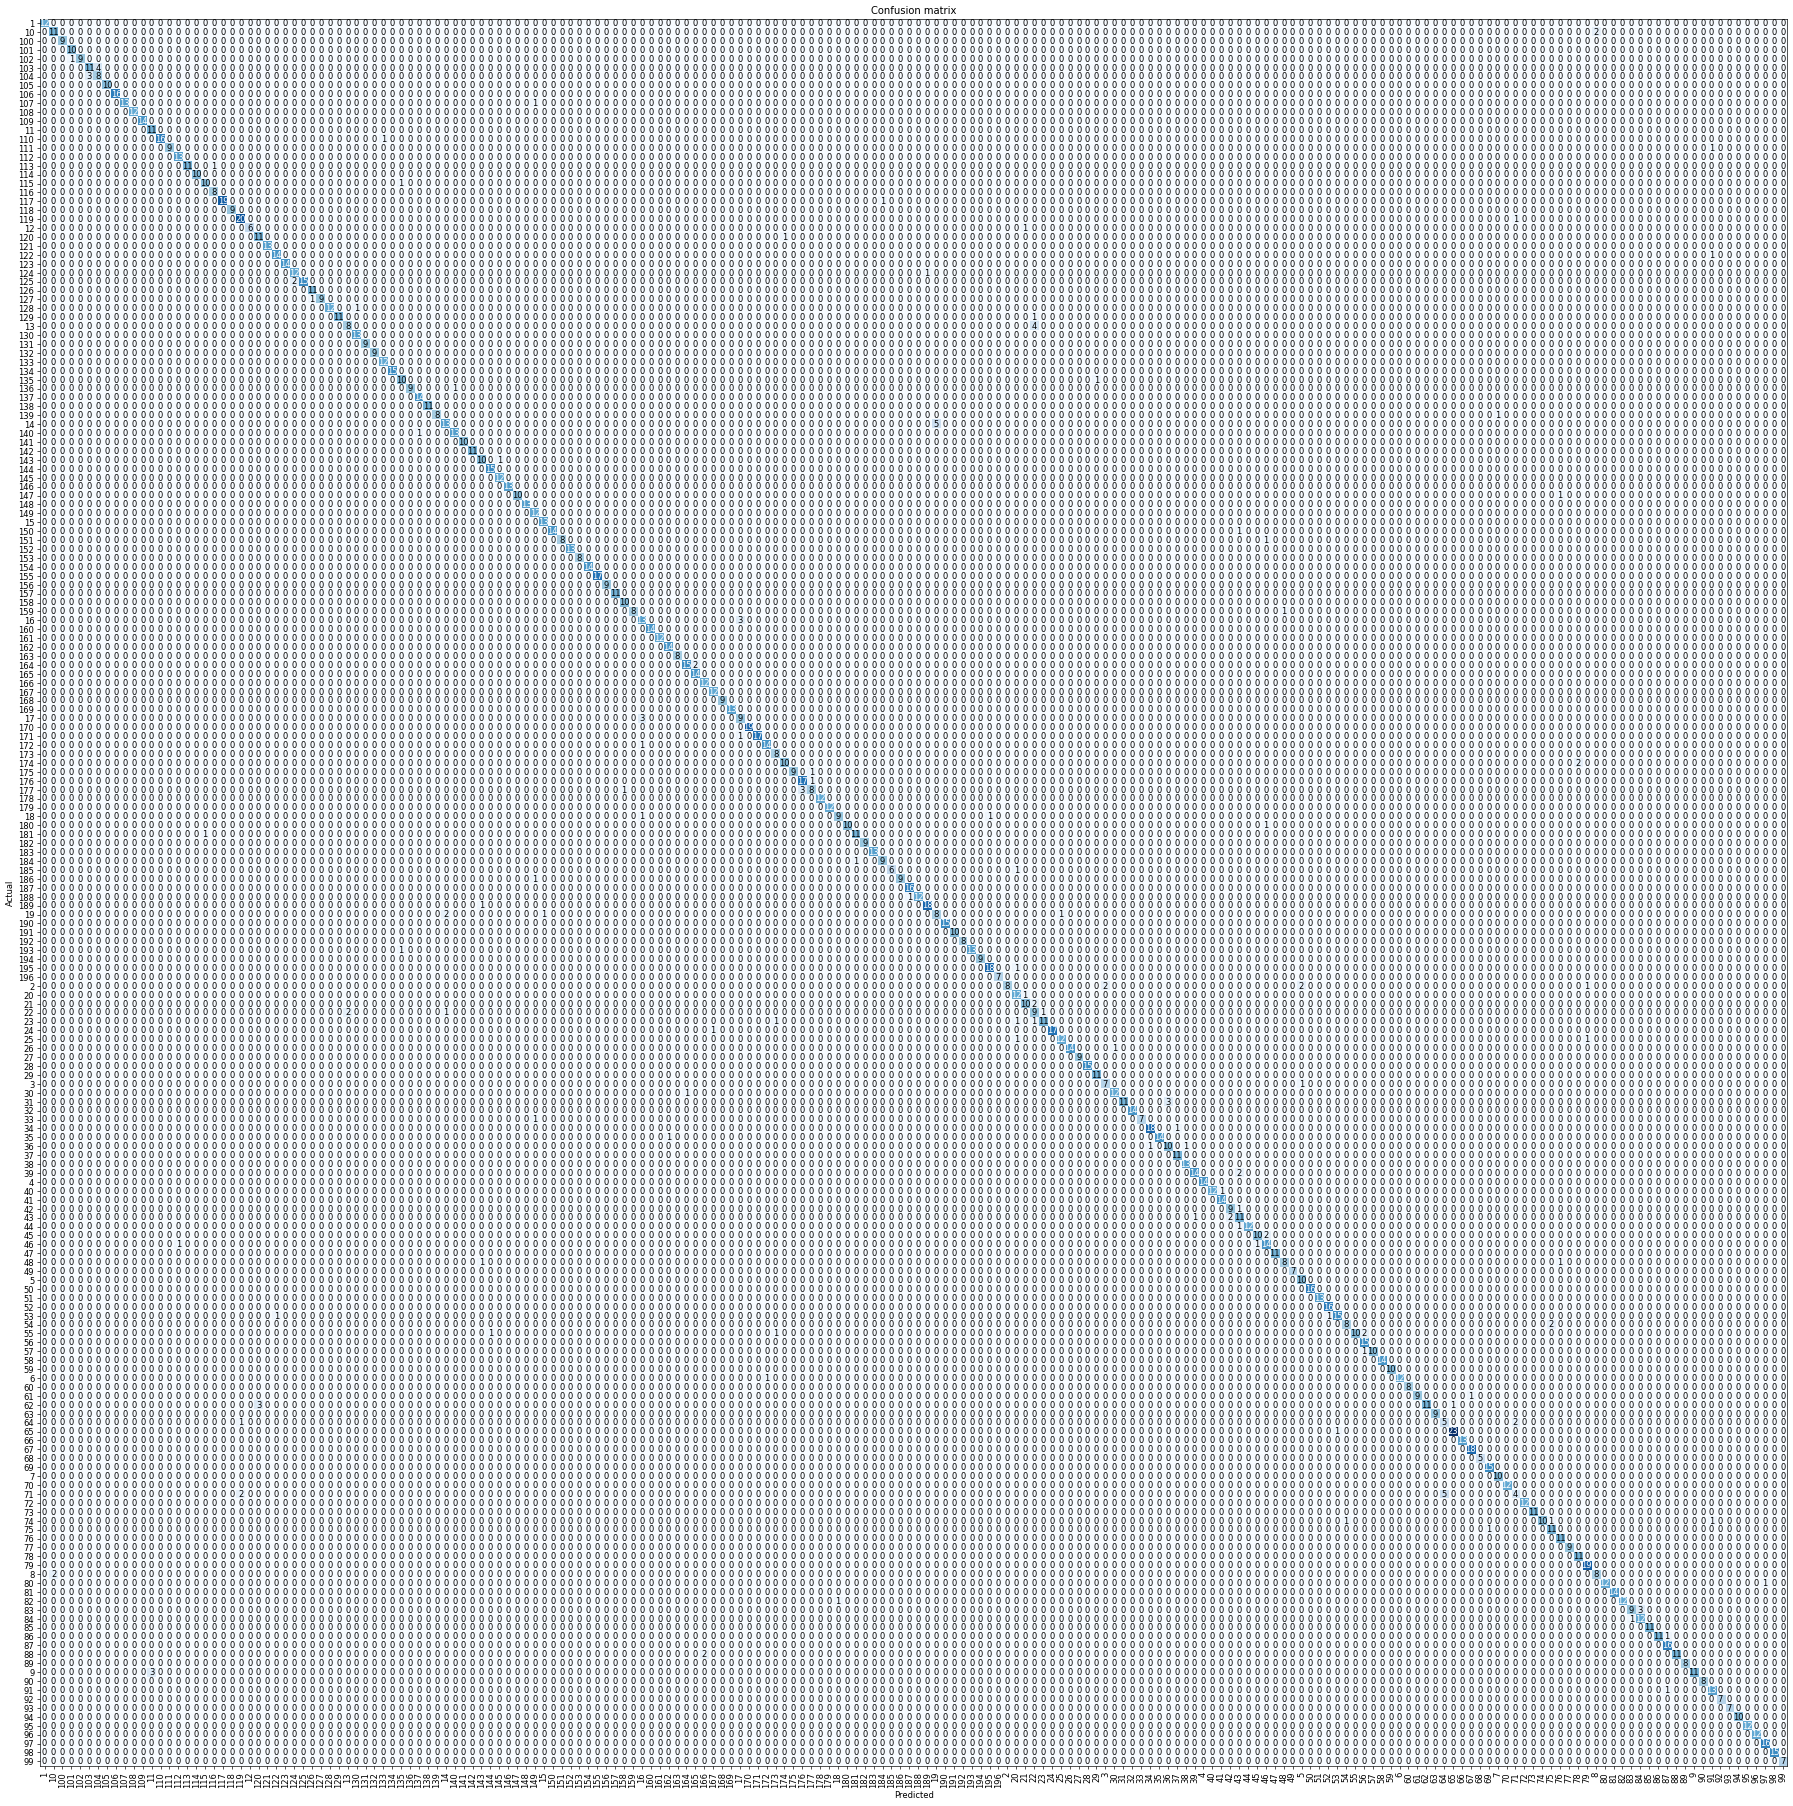

In [28]:
random_seed(42,True)
interp = ClassificationInterpretation.from_learner(learn2)
interp.plot_confusion_matrix(figsize = (30, 30), dpi = 60)

In [29]:
interp.most_confused(min_val = 6)

[]

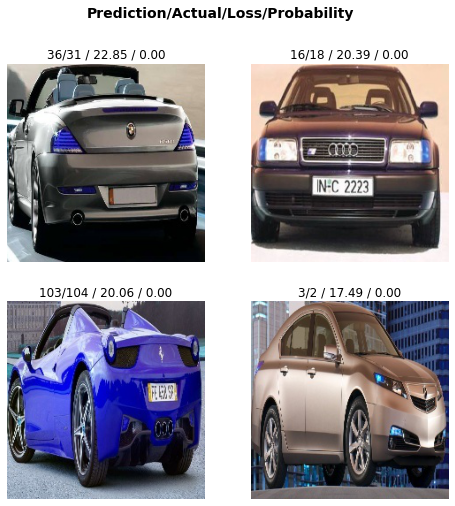

In [30]:
interp.plot_top_losses(4, figsize = (8, 8))

In [31]:
from tqdm import tqdm

In [37]:
#Evaluation
df_test_new = pd.read_csv('/content/drive/MyDrive/Simcoe/894/Car dataset/df_test_new.csv')
actual_tup = df_test_new[['img_name','class']].to_records(index=False)
actual_tup = list(actual_tup)

preds = []
dataIndex = []
num_preds = len(actual_tup)
for i in tqdm(range(num_preds)):
    random_seed(42,True)
    p = learn2.predict(data.test_ds.x[i])
    preds.append(str(p[0]))
    dataIndex.append(str(learn1.data.test_ds.items[i]).split('/')[-1])

dataIndex1 = np.asarray(dataIndex)
preds = list(map(int, preds))
pred_tup = list(zip(dataIndex1,preds))
pred_tup.sort()

df_pred = pd.DataFrame(pred_tup,columns=['img_name','pred_class'])
df_valid = df_test_new.merge(df_pred, left_on='img_name', right_on='img_name')

feature_list1 = ['img_name','class','pred_class']
df_valid1 = df_valid[feature_list1]

df_valid1['diff'] = np.where(df_valid1['class'] == df_valid1['pred_class'],1,0)
accuracy = df_valid1['diff'].sum()/df_valid1.shape[0]
accuracy


precision, recall, fscore, support = precision_recall_fscore_support(df_valid1['class'].values, df_valid1['pred_class'].values, average = 'weighted')
print('The precision score is', precision, '\nThe recall score is', recall, '\nThe fscore score is', fscore, '\nThe accuracy score is', accuracy)

100%|██████████| 2427/2427 [00:26<00:00, 90.47it/s]

The precision score is 0.9280420202740958 
The recall score is 0.9208899876390606 
The fscore score is 0.9209202167802918 
The accuracy score is 0.9208899876390606



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
